In [ ]:
# univariate LSTM example
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
 
import datetime
import statistics as stats
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
 
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

In [ ]:
SCREEN_X, SCREEN_Y = 12, 8
 
def CryptoData(symbol, frequency, start=0):
    #Params: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    url ='https://poloniex.com/public?command=returnChartData&currencyPair='+symbol+'&end=9999999999&period='+str(frequency)+'&start='+str(start)
    df = pd.read_json(url)
    df.set_index('date',inplace=True)
    return df
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
 
def getPrediction(lstm, raw_seq, index, n_steps, n_features):
  x_seq = raw_seq[index-n_steps : index]
  x_seq = x_seq.reshape(1, n_steps, n_features)
  
  yhat = lstm.predict(x_seq)
  y = raw_seq[index]
  
  return x_seq, yhat, y
 
 
# predict the next day close as the same as today's close 
def getBasePrediction(raw_seq, index, n_steps):
  x_seq = raw_seq[index-n_steps : index]
  
  yhat = x_seq[len(x_seq)-1]
  y = raw_seq[index]
  
  return x_seq, yhat, y
 
 
def roundNum(num, dp=2):
    return round(num, dp)

In [ ]:
startDate = int((datetime.datetime.strptime('1/1/2020', "%d/%m/%Y").timestamp()))
testSymbol = 'USDT_BTC' #bitCoin
# frequency = 86400s which is 1 day
df = CryptoData(testSymbol, 86400, startDate)
df


,high,low,open,close,volume,quoteVolume,weightedAverage
date,,,,,,,
2020-01-01,7254.498960,7174.932597,7193.736944,7201.563166,2.453360e+07,3398.560569,7218.820320
2020-01-02,7211.745123,6933.790000,7198.222658,6965.965771,2.556236e+07,3595.469846,7109.601796
2020-01-03,7402.000000,6870.861302,6964.868614,7344.840128,3.608028e+07,5002.018583,7213.144896
2020-01-04,7403.040213,7274.123499,7344.654551,7352.474126,3.102271e+07,4231.478388,7331.412033
2020-01-05,7495.000000,7320.148910,7353.499671,7359.668224,3.230619e+07,4344.692196,7435.782837
...,...,...,...,...,...,...,...
2021-02-26,48448.570888,44122.216031,47046.151566,46310.000000,9.575805e+07,2059.518789,46495.349798
2021-02-27,48388.981486,45000.000000,46320.000000,46121.948326,5.693021e+07,1209.947413,47051.807150
2021-02-28,46615.782170,43000.000000,46116.196781,45170.087409,8.121885e+07,1818.373197,44665.663770


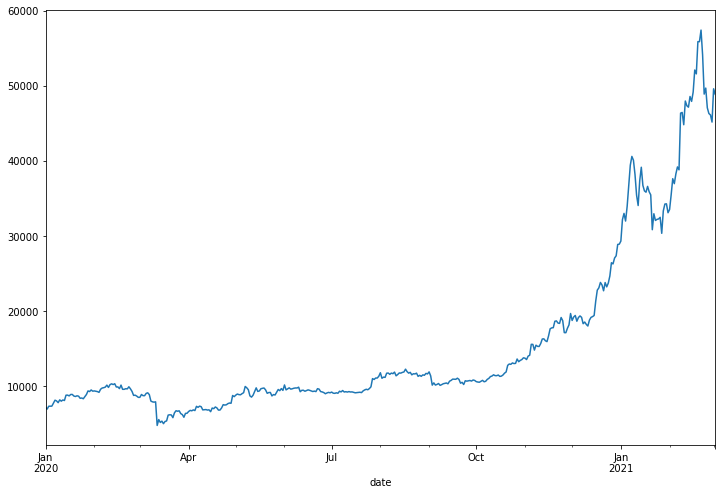

In [ ]:
df['close'].plot(figsize = (SCREEN_X, SCREEN_Y))

In [ ]:
# define input sequence and no. of features
# Use only the "close" price as the input feature
raw_seq = df['close'].values
n_features = raw_seq.ndim  #raw_seq's dimension
data_size = len(raw_seq)

print("n_features:", n_features) 
print("data_size:", data_size)

n_features: 1
data_size: 427


In [ ]:
# split the data into training and test set
train_ratio = 0.8
train_size = round(train_ratio * data_size)
train_seq = raw_seq[:train_size]
test_seq = raw_seq[train_size:]

print("train_size:", train_size)
print("test_size:", data_size-train_size)

train_size: 342
test_size: 85


In [ ]:
# choose a number of time steps
n_steps = 7

# split into training samples
x_train, y_train = split_sequence(train_seq, n_steps)

# reshape from [samples, timesteps] to [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], n_features)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (335, 7, 1)
y_train shape: (335,)


In [ ]:
index = 0
print(x_train[index])
print('--->', y_train[index])

[[7201.56316558]
 [6965.96577138]
 [7344.84012792]
 [7352.47412649]
 [7359.66822393]
 [7756.35259299]
 [8150.7253787 ]]
---> 8052.34312978


In [ ]:
index = 1
print(x_train[index])
print('--->', y_train[index])

[[6965.96577138]
 [7344.84012792]
 [7352.47412649]
 [7359.66822393]
 [7756.35259299]
 [8150.7253787 ]
 [8052.34312978]]
---> 7821.52457833


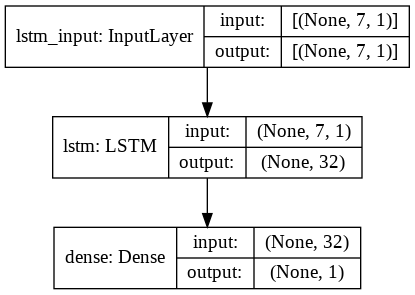

In [ ]:
# define the LTSM model
# The number of hidden neurons in LSTM does not directly relate to the timestep 
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()
# The lstm (LSTM) Param # = g * [h(h+i) + h]
# where g is number of gates and LSTM = 4
# h = no. of LSTM hidden neurons
# i = the dimension of input (feature)
# 4 * (32 (32 + 1) + 32) = 4352

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
11/11 [==============================] - 1s 4ms/step - loss: 149511632.0000
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 129531216.6667
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 120578501.3333
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 126561938.6667
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 116585580.0000
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 118778398.6667
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 113409576.6667
Epoch 8/20
11/11 [==============================] - 0s 4ms/step - loss: 114131013.3333
Epoch 9/20
11/11 [==============================] - 0s 4ms/step - loss: 110444216.6667
Epoch 10/20
11/11 [==============================] - 0s 5ms/step - loss: 115188131.3333
Epoch 11/20
11/11 [==============================] - 0s 4ms/step - loss: 113805786.0000
Epoch 12/20
11/11 [======================

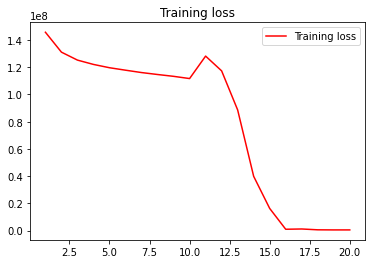

In [ ]:
# fit model
history = model.fit(x_train, y_train, epochs=20)

# Plot the loss
loss = history.history['loss']
epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [ ]:
# predict the next day
index = train_size
x_seq, yhat, y = getPrediction(model, raw_seq, index, n_steps, n_features)

predicted = yhat[0][0]
actual = y
error = actual - predicted
errorP = abs(error) / predicted

print(x_seq, "\n")
print("Predicted:", predicted)
print("Actual:", actual)
print("Error:", error)
print("Error%:", roundNum(errorP, 4)*100)

[[[18763.44978084]
  [19225.36801549]
  [19428.82938015]
  [18661.57242051]
  [19153.89663718]
  [19365.67730053]
  [19179.75841217]]] 

Predicted: 19213.684
Actual: 18330.0
Error: -883.68359375
Error%: 4.6


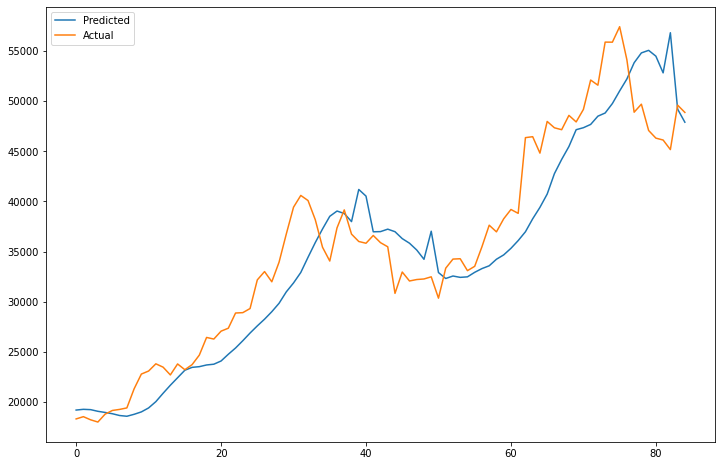

In [ ]:
# Predict the rest of the series and comparing to the test set
# Each prediction is based on the "actual" observation from the past days
# Another way is to use multi-step ahead output or
# use the predicted values as new observations to further predict the rest of the series

predictedList = []
actualList = []

for i in range(train_size, data_size):
  x_seq, yhat, y = getPrediction(model, raw_seq, i, n_steps, n_features)
  predictedList.append(yhat[0][0])
  actualList.append(y)

# plot the result
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(predictedList, label="Predicted")
plt.plot(actualList, label="Actual")
plt.legend()

In [ ]:
# look at the individual predictions
lstmError = []
lstmErrorP = []
for i in range(len(predictedList)):
  error = actualList[i]-predictedList[i]
  absError = abs(error)
  errorP = absError/actualList[i]
  lstmError.append(absError)
  lstmErrorP.append(errorP)

  print("Predicted:", roundNum(predictedList[i]),
       "  Actual:", roundNum(actualList[i]),
       "  Error:", roundNum(error), 
        "->", roundNum(errorP), sep='')

print("--------------------------------------")  
print("Error: Total=",roundNum(sum(lstmError)), " Average=",roundNum(stats.mean(lstmError)), " Min=",roundNum(min(lstmError)), " Max=",roundNum(max(lstmError)), sep='')
print("Error Ratio: Average=",roundNum(stats.mean(lstmErrorP)), " Min=",roundNum(min(lstmErrorP)), " Max=",roundNum(max(lstmErrorP)), sep='')

Predicted:19213.68  Actual:18330.0  Error:-883.68->0.05
Predicted:19287.09  Actual:18554.98  Error:-732.11->0.04
Predicted:19254.72  Actual:18241.23  Error:-1013.49->0.06
Predicted:19089.29  Actual:18020.41  Error:-1068.88->0.06
Predicted:18975.12  Actual:18806.43  Error:-168.68->0.01
Predicted:18847.74  Actual:19173.09  Error:325.35->0.02
Predicted:18669.06  Actual:19278.77  Error:609.71->0.03
Predicted:18596.36  Actual:19426.77  Error:830.41->0.04
Predicted:18790.06  Actual:21329.05  Error:2538.99->0.12
Predicted:19029.93  Actual:22800.29  Error:3770.36->0.17
Predicted:19425.36  Actual:23102.47  Error:3677.11->0.16
Predicted:20052.28  Actual:23821.7  Error:3769.42->0.16
Predicted:20886.08  Actual:23488.58  Error:2602.5->0.11
Predicted:21686.01  Actual:22713.86  Error:1027.85->0.05
Predicted:22434.51  Actual:23808.33  Error:1373.82->0.06
Predicted:23180.4  Actual:23235.17  Error:54.78->0.0
Predicted:23469.51  Actual:23738.86  Error:269.35->0.01
Predicted:23538.27  Actual:24690.6  Erro

In [ ]:
# Baseline comparison: predict the next day close as the same as today's close
basePredictedList = []
baseActualList = []

for i in range(train_size, data_size):
  x_seq, yhat, y = getBasePrediction(raw_seq, i, n_steps)
  basePredictedList.append(yhat)
  baseActualList.append(y)


# look at the individual predictions
baseError = []
baseErrorP = []
for i in range(len(basePredictedList)):
  error = baseActualList[i]-basePredictedList[i]
  absError = abs(error)
  errorP = absError/baseActualList[i]
  baseError.append(absError)
  baseErrorP.append(errorP)

  print("Predicted:", roundNum(basePredictedList[i]),
       "  Actual:", roundNum(baseActualList[i]),
       "  Error:", roundNum(error), 
        "->", roundNum(errorP), sep='')

print("--------------------------------------")  
print("Error: Total=",roundNum(sum(baseError)), " Average=",roundNum(stats.mean(baseError)), " Min=",roundNum(min(baseError)), " Max=",roundNum(max(baseError)), sep='')
print("Error Ratio: Average=",roundNum(stats.mean(baseErrorP)), " Min=",roundNum(min(baseErrorP)), " Max=",roundNum(max(baseErrorP)), sep='')


Predicted:19179.76  Actual:18330.0  Error:-849.76->0.05
Predicted:18330.0  Actual:18554.98  Error:224.98->0.01
Predicted:18554.98  Actual:18241.23  Error:-313.75->0.02
Predicted:18241.23  Actual:18020.41  Error:-220.82->0.01
Predicted:18020.41  Actual:18806.43  Error:786.03->0.04
Predicted:18806.43  Actual:19173.09  Error:366.66->0.02
Predicted:19173.09  Actual:19278.77  Error:105.68->0.01
Predicted:19278.77  Actual:19426.77  Error:148.0->0.01
Predicted:19426.77  Actual:21329.05  Error:1902.28->0.09
Predicted:21329.05  Actual:22800.29  Error:1471.24->0.06
Predicted:22800.29  Actual:23102.47  Error:302.18->0.01
Predicted:23102.47  Actual:23821.7  Error:719.23->0.03
Predicted:23821.7  Actual:23488.58  Error:-333.12->0.01
Predicted:23488.58  Actual:22713.86  Error:-774.72->0.03
Predicted:22713.86  Actual:23808.33  Error:1094.47->0.05
Predicted:23808.33  Actual:23235.17  Error:-573.16->0.02
Predicted:23235.17  Actual:23738.86  Error:503.69->0.02
Predicted:23738.86  Actual:24690.6  Error:95

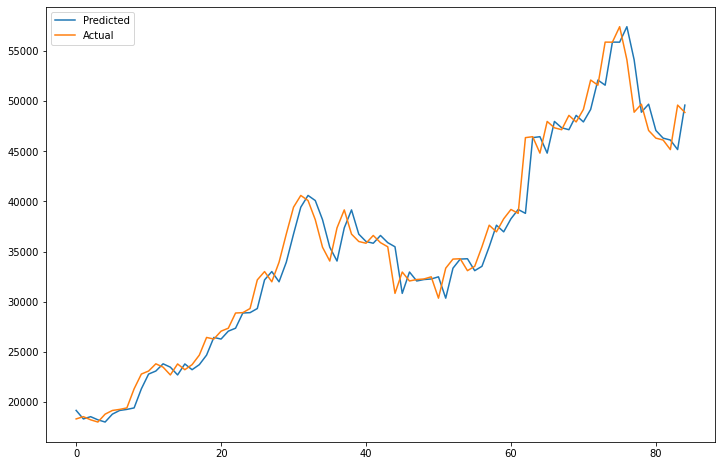

In [ ]:
# plot base result
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(basePredictedList, label="Predicted")
plt.plot(baseActualList, label="Actual")
plt.legend()

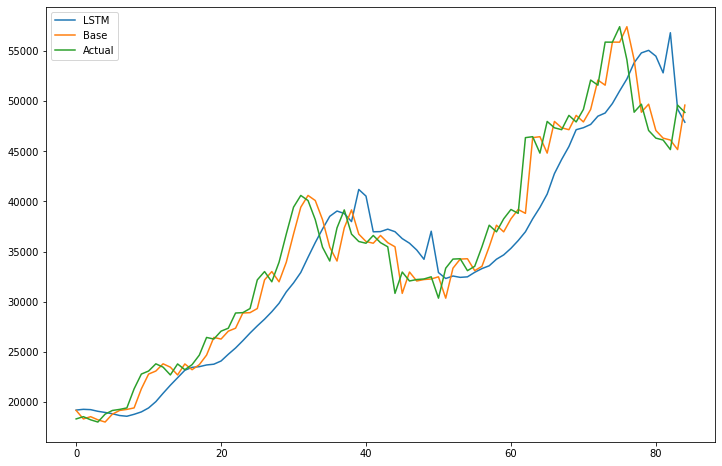

In [ ]:
# plot all results
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(predictedList, label="LSTM")
plt.plot(basePredictedList, label="Base")
plt.plot(baseActualList, label="Actual")
plt.legend()

In [ ]:
#converting lists to df
df_combined_BTC = pd.DataFrame(
              {'LSTM': predictedList,
               'Base': basePredictedList,
               'Actual': baseActualList
              })


df_combined_BTC

,LSTM,Base,Actual
0,19213.683594,19179.758412,18330.000000
1,19287.091797,18330.000000,18554.976870
2,19254.718750,18554.976870,18241.229499
3,19089.291016,18241.229499,18020.408163
4,18975.117188,18020.408163,18806.434717
...,...,...,...
80,54477.984375,47071.988756,46310.000000
81,52814.117188,46310.000000,46121.948326
82,56812.851562,46121.948326,45170.087409
83,49201.832031,45170.087409,49601.293720


In [ ]:
#Buy BTC when LSTM predicted is higher then Actual

df_combined_BTC = df_combined_BTC.dropna()

s1 = df_combined_BTC['LSTM'] < df_combined_BTC['Actual']
s2 = df_combined_BTC['Actual'] > df_combined_BTC['LSTM']
buyBTC = df_combined_BTC[~(s1 | s2.shift(1))]

print("\nPotential transaction date(s): \n")  #
print(buyBTC[[ "LSTM","Actual"]])

#Buy BTC
buyBTC_sum = round(buyBTC["Actual"].sum(),2)   ##
print("\nTotal cost for all BTC: ",buyBTC_sum)

buyBTC_number = len(buyBTC)
print("The number of BTC owned:", buyBTC_number)  ###

BTC_value = df_combined_BTC["Actual"].iloc[-1]
print("Current BTC price: ", BTC_value)    ####

BTC_value_total = BTC_value * buyBTC_number
print("Total value of all BTC owned: ", BTC_value_total)

BTC_revenue = - buyBTC_sum + BTC_value_total
print("Total revenue: ", BTC_revenue)    #####


Potential transaction date(s): 

            LSTM        Actual
0   19213.683594  18330.000000
1   19287.091797  18554.976870
2   19254.718750  18241.229499
3   19089.291016  18020.408163
4   18975.117188  18806.434717
35  38519.597656  34063.088645
36  39045.417969  37369.239261
39  41195.320312  36011.108674
40  40532.503906  35835.931579
41  36977.539062  36610.629133
42  36995.664062  35894.656128
43  37239.609375  35482.968972
44  36986.816406  30841.827991
45  36297.363281  32969.666718
46  35839.722656  32074.953756
47  35161.777344  32220.319239
48  34236.628906  32275.900074
49  37033.585938  32490.948488
50  32915.464844  30363.055003
78  54802.921875  49694.850275
79  55057.738281  47071.988756
80  54477.984375  46310.000000
81  52814.117188  46121.948326
82  56812.851562  45170.087409

Total cost for all BTC:  800826.22
The number of BTC owned: 24
Current BTC price:  48872.0
Total value of all BTC owned:  1172928.0
Total revenue:  372101.78


In [ ]:
startDate = int((datetime.datetime.strptime('1/1/2020', "%d/%m/%Y").timestamp()))
testSymbol = 'USDT_ETH' #Ether/ETH
# frequency = 86400s which is 1 day
df = CryptoData(testSymbol, 86400, startDate)
df

,high,low,open,close,volume,quoteVolume,weightedAverage
date,,,,,,,
2020-01-01,132.978118,128.644149,129.105646,130.668215,4.585569e+06,34928.591735,131.284113
2020-01-02,130.778688,126.292474,130.642440,127.210000,5.045582e+06,39310.023603,128.353580
2020-01-03,135.000000,125.845390,127.198410,134.548843,8.995060e+06,68884.952729,130.580908
2020-01-04,135.816151,132.540971,134.420649,134.174395,5.820436e+06,43542.896638,133.671310
2020-01-05,138.300000,134.174395,134.201951,135.422873,7.868584e+06,57796.702234,136.142443
...,...,...,...,...,...,...,...
2021-02-26,1562.125696,1398.948130,1481.916877,1445.978916,7.509271e+07,50688.446868,1481.456180
2021-02-27,1528.000000,1426.000000,1446.279338,1458.531622,4.638983e+07,31222.861423,1485.764690
2021-02-28,1467.856317,1294.620392,1455.402249,1418.700322,7.239018e+07,52805.499821,1370.883272


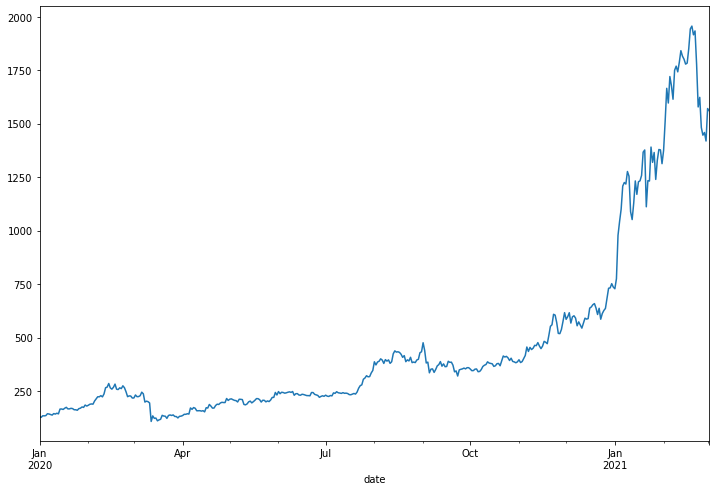

In [ ]:
df['close'].plot(figsize = (SCREEN_X, SCREEN_Y))

In [ ]:
# define input sequence and no. of features
# Use only the "close" price as the input feature
raw_seq = df['close'].values
n_features = raw_seq.ndim
data_size = len(raw_seq)

print("n_features:", n_features) 
print("data_size:", data_size)

n_features: 1
data_size: 427


In [ ]:
# split the data into training and test set
train_ratio = 0.8
train_size = round(train_ratio * data_size)
train_seq = raw_seq[:train_size]
test_seq = raw_seq[train_size:]

print("train_size:", train_size)
print("test_size:", data_size-train_size)

train_size: 342
test_size: 85


In [ ]:
# choose a number of time steps
n_steps = 7

# split into training samples
x_train, y_train = split_sequence(train_seq, n_steps)

# reshape from [samples, timesteps] to [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], n_features)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (335, 7, 1)
y_train shape: (335,)


In [ ]:
index = 0
print(x_train[index])
print('--->', y_train[index])

[[130.66821479]
 [127.20999996]
 [134.54884259]
 [134.17439463]
 [135.42287283]
 [144.17792225]
 [142.86972564]]
---> 140.59861832


In [ ]:
index = 1
print(x_train[index])
print('--->', y_train[index])

[[127.20999996]
 [134.54884259]
 [134.17439463]
 [135.42287283]
 [144.17792225]
 [142.86972564]
 [140.59861832]]
---> 137.82794923


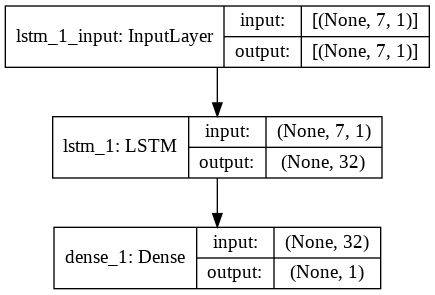

In [ ]:
# define the LTSM model
# The number of hidden neurons in LSTM does not directly relate to the timestep 
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()
# The lstm (LSTM) Param # = g * [h(h+i) + h]
# where g is number of gates and LSTM = 4
# h = no. of LSTM hidden neurons
# i = the dimension of input (feature)
# 4 * (32 (32 + 1) + 32) = 4352

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
11/11 [==============================] - 1s 4ms/step - loss: 107658.8789
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 99543.7402
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 108332.8464
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 98790.6204
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 96084.9193
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 80644.3939
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 56800.2406
Epoch 8/20
11/11 [==============================] - 0s 4ms/step - loss: 3720.0480
Epoch 9/20
11/11 [==============================] - 0s 4ms/step - loss: 678.8775
Epoch 10/20
11/11 [==============================] - 0s 4ms/step - loss: 647.7358
Epoch 11/20
11/11 [==============================] - 0s 4ms/step - loss: 542.4932
Epoch 12/20
11/11 [==============================] - 0s 4ms/step - loss: 461.5411
Epoch 13

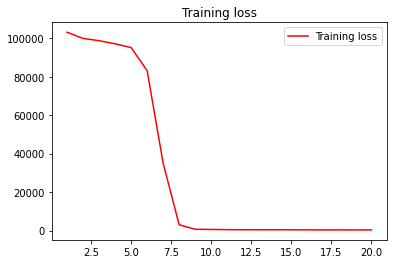

In [ ]:
# fit model
history = model.fit(x_train, y_train, epochs=20)

# Plot the loss
loss = history.history['loss']
epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [ ]:
# predict the next day
index = train_size
x_seq, yhat, y = getPrediction(model, raw_seq, index, n_steps, n_features)

predicted = yhat[0][0]
actual = y
error = actual - predicted
errorP = abs(error) / predicted

print(x_seq, "\n")
print("Predicted:", predicted)
print("Actual:", actual)
print("Error:", error)
print("Error%:", roundNum(errorP, 4)*100)

[[[585.28      ]
  [597.61278895]
  [616.24757228]
  [567.78627496]
  [596.97233942]
  [601.9       ]
  [591.02320424]]] 

Predicted: 593.36914
Actual: 555.22718756
Error: -38.14195306500005
Error%: 6.43


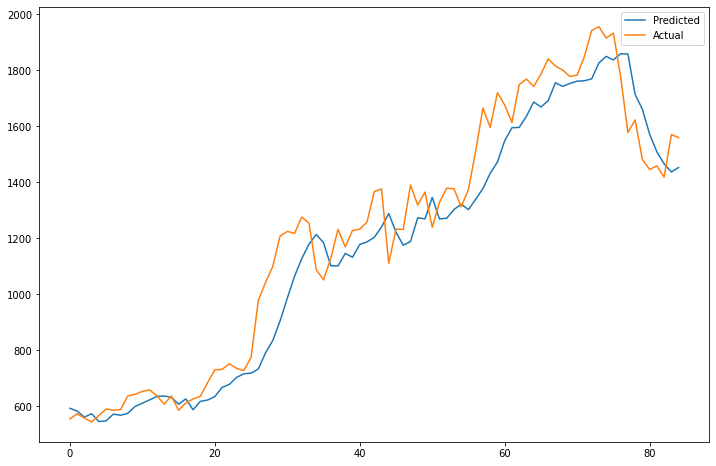

In [ ]:
# Predict the rest of the series and comparing to the test set
# Each prediction is based on the "actual" observation from the past days
# Another way is to use multi-step ahead output or
# use the predicted values as new observations to further predict the rest of the series

predictedList = []
actualList = []

for i in range(train_size, data_size):
  x_seq, yhat, y = getPrediction(model, raw_seq, i, n_steps, n_features)
  predictedList.append(yhat[0][0])
  actualList.append(y)

# plot the result
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(predictedList, label="Predicted")
plt.plot(actualList, label="Actual")
plt.legend()

In [ ]:
# look at the individual predictions
lstmError = []
lstmErrorP = []
for i in range(len(predictedList)):
  error = actualList[i]-predictedList[i]
  absError = abs(error)
  errorP = absError/actualList[i]
  lstmError.append(absError)
  lstmErrorP.append(errorP)

  print("Predicted:", roundNum(predictedList[i]),
       "  Actual:", roundNum(actualList[i]),
       "  Error:", roundNum(error), 
        "->", roundNum(errorP), sep='')

print("--------------------------------------")  
print("Error: Total=",roundNum(sum(lstmError)), " Average=",roundNum(stats.mean(lstmError)), " Min=",roundNum(min(lstmError)), " Max=",roundNum(max(lstmError)), sep='')
print("Error Ratio: Average=",roundNum(stats.mean(lstmErrorP)), " Min=",roundNum(min(lstmErrorP)), " Max=",roundNum(max(lstmErrorP)), sep='')

Predicted:593.37  Actual:555.23  Error:-38.14->0.07
Predicted:583.37  Actual:573.42  Error:-9.95->0.02
Predicted:561.89  Actual:558.42  Error:-3.47->0.01
Predicted:573.99  Actual:544.23  Error:-29.76->0.05
Predicted:545.99  Actual:567.55  Error:21.56->0.04
Predicted:548.48  Actual:590.74  Error:42.26->0.07
Predicted:572.49  Actual:586.27  Error:13.78->0.02
Predicted:568.4  Actual:588.7  Error:20.3->0.03
Predicted:575.52  Actual:637.74  Error:62.22->0.1
Predicted:599.87  Actual:643.18  Error:43.31->0.07
Predicted:611.45  Actual:653.61  Error:42.16->0.06
Predicted:623.39  Actual:658.89  Error:35.5->0.05
Predicted:635.54  Actual:638.4  Error:2.86->0.0
Predicted:637.43  Actual:608.0  Error:-29.43->0.05
Predicted:632.14  Actual:636.98  Error:4.85->0.01
Predicted:607.98  Actual:585.89  Error:-22.09->0.04
Predicted:626.88  Actual:612.43  Error:-14.45->0.02
Predicted:588.06  Actual:626.71  Error:38.64->0.06
Predicted:617.98  Actual:636.34  Error:18.36->0.03
Predicted:622.68  Actual:684.69  Err

In [ ]:
# Baseline comparison: predict the next day close as the same as today's close
basePredictedList = []
baseActualList = []

for i in range(train_size, data_size):
  x_seq, yhat, y = getBasePrediction(raw_seq, i, n_steps)
  basePredictedList.append(yhat)
  baseActualList.append(y)


# look at the individual predictions
baseError = []
baseErrorP = []
for i in range(len(basePredictedList)):
  error = baseActualList[i]-basePredictedList[i]
  absError = abs(error)
  errorP = absError/baseActualList[i]
  baseError.append(absError)
  baseErrorP.append(errorP)

  print("Predicted:", roundNum(basePredictedList[i]),
       "  Actual:", roundNum(baseActualList[i]),
       "  Error:", roundNum(error), 
        "->", roundNum(errorP), sep='')

print("--------------------------------------")  
print("Error: Total=",roundNum(sum(baseError)), " Average=",roundNum(stats.mean(baseError)), " Min=",roundNum(min(baseError)), " Max=",roundNum(max(baseError)), sep='')
print("Error Ratio: Average=",roundNum(stats.mean(baseErrorP)), " Min=",roundNum(min(baseErrorP)), " Max=",roundNum(max(baseErrorP)), sep='')


Predicted:591.02  Actual:555.23  Error:-35.8->0.06
Predicted:555.23  Actual:573.42  Error:18.19->0.03
Predicted:573.42  Actual:558.42  Error:-14.99->0.03
Predicted:558.42  Actual:544.23  Error:-14.19->0.03
Predicted:544.23  Actual:567.55  Error:23.32->0.04
Predicted:567.55  Actual:590.74  Error:23.19->0.04
Predicted:590.74  Actual:586.27  Error:-4.48->0.01
Predicted:586.27  Actual:588.7  Error:2.43->0.0
Predicted:588.7  Actual:637.74  Error:49.04->0.08
Predicted:637.74  Actual:643.18  Error:5.44->0.01
Predicted:643.18  Actual:653.61  Error:10.43->0.02
Predicted:653.61  Actual:658.89  Error:5.28->0.01
Predicted:658.89  Actual:638.4  Error:-20.49->0.03
Predicted:638.4  Actual:608.0  Error:-30.4->0.05
Predicted:608.0  Actual:636.98  Error:28.98->0.05
Predicted:636.98  Actual:585.89  Error:-51.09->0.09
Predicted:585.89  Actual:612.43  Error:26.54->0.04
Predicted:612.43  Actual:626.71  Error:14.27->0.02
Predicted:626.71  Actual:636.34  Error:9.63->0.02
Predicted:636.34  Actual:684.69  Error

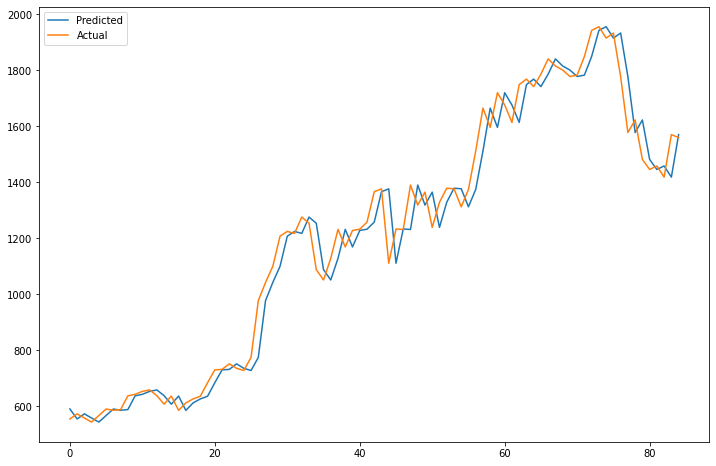

In [ ]:
# plot base result
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(basePredictedList, label="Predicted")
plt.plot(baseActualList, label="Actual")
plt.legend()

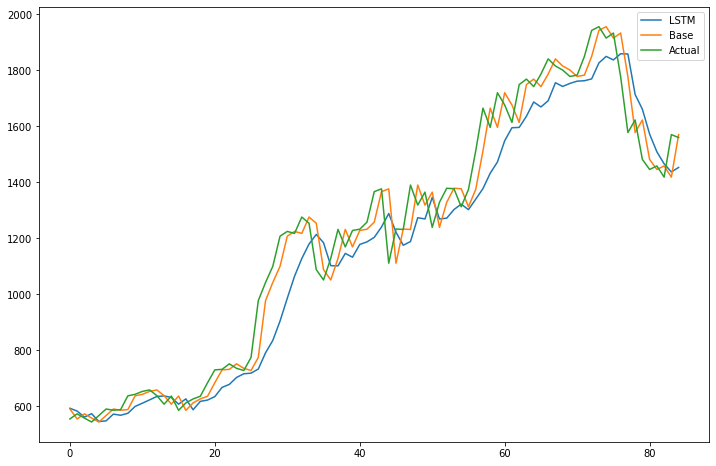

In [ ]:
# plot all results
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(predictedList, label="LSTM")
plt.plot(basePredictedList, label="Base")
plt.plot(baseActualList, label="Actual")
plt.legend()

In [ ]:
#converting lists to df
df_combined_ETH = pd.DataFrame(
              {'LSTM': predictedList,
               'Base': basePredictedList,
               'Actual': baseActualList
              })


df_combined_ETH

,LSTM,Base,Actual
0,593.369141,591.023204,555.227188
1,583.367188,555.227188,573.415222
2,561.888489,573.415222,558.422112
3,573.985901,558.422112,544.230554
4,545.991821,544.230554,567.551000
...,...,...,...
80,1572.194580,1481.856575,1445.978916
81,1509.056641,1445.978916,1458.531622
82,1466.242188,1458.531622,1418.700322
83,1437.183105,1418.700322,1570.549600


In [ ]:
#Buy ETH when LSTM predicted is higher then Actual

df_combined_ETH = df_combined_ETH.dropna()

s1 = df_combined_ETH['LSTM'] < df_combined_ETH['Actual']
s2 = df_combined_ETH['Actual'] > df_combined_ETH['LSTM']
buyETH = df_combined_ETH[~(s1 | s2.shift(1))]

print("\nPotential transaction date(s): \n")
print(buyETH[[ "LSTM","Actual"]])

#Buy ETH
buyETH_sum = round(buyETH["Actual"].sum(),2)
print("\nTotal cost for all ETH: ",buyETH_sum)

buyETH_number = len(buyETH)
print("The number of ETH owned:", buyETH_number)

ETH_value = df_combined_ETH["Actual"].iloc[-1]
print("Current ETH price: ", ETH_value)

ETH_value_total = ETH_value * buyETH_number
print("Total value of all ETH owned: ", ETH_value_total)

ETH_revenue = - buyETH_sum + ETH_value_total
print("Total revenue: ", ETH_revenue)


Potential transaction date(s): 

           LSTM       Actual
0    593.369141   555.227188
1    583.367188   573.415222
2    561.888489   558.422112
3    573.985901   544.230554
16   626.881287   612.433577
35  1184.451172  1051.523070
77  1858.308105  1577.936919
78  1713.731934  1622.739266
79  1661.160522  1481.856575
80  1572.194580  1445.978916
81  1509.056641  1458.531622
82  1466.242188  1418.700322

Total cost for all ETH:  12901.0
The number of ETH owned: 12
Current ETH price:  1559.90712789
Total value of all ETH owned:  18718.88553468
Total revenue:  5817.885534680001
